# Dataset Overview

The Human Activity Recognition Trondheim (HARTH) dataset comprises recordings from 22 participants, each wearing two 3-axial Axivity AX3 accelerometers for approximately 2 hours in a free-living environment. The sensors, positioned on the right thigh and lower back, capture motion data essential for human activity recognition (HAR). This dataset's rich, professionally annotated data offers a comprehensive benchmark for developing advanced machine learning models aimed at precise HAR in real-world settings.

- **Subject Area**: Computer Science, specifically focused on Human Activity Recognition.
- **Dataset Characteristics**: Multivariate, Time-Series.
- **Associated Tasks**: Classification.
- **Feature Type**: Real-valued sensor data.
- **Sampling Rate**: 50Hz.
- **Annotations**: Activities annotated frame-by-frame using video recordings from a chest-mounted camera.
- **Total Instances**: 6,461,328.
- **Total Features**: 8, including sensor readings (`back_x`, `back_y`, `back_z`, `thigh_x`, `thigh_y`, `thigh_z`).

## Import Libraries


In [1]:
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import zipfile
import os
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Concatenate, Dropout, BatchNormalization, Activation

## Load the Dataset

In [2]:
# URL for UCI data
zip_file_url = "https://archive.ics.uci.edu/static/public/779/harth.zip"
files = [
    'S029.csv', 'S028.csv', 'S027.csv', 'S026.csv', 'S025.csv',
    'S024.csv', 'S023.csv', 'S022.csv', 'S021.csv', 'S020.csv',
    'S019.csv', 'S018.csv', 'S017.csv', 'S016.csv', 'S015.csv',
    'S014.csv', 'S013.csv', 'S012.csv', 'S010.csv', 'S009.csv',
    'S008.csv', 'S006.csv',
]
data_types = {
    'back_x': 'float64', 'back_y': 'float64', 'back_z': 'float64',
    'thigh_x': 'float64', 'thigh_y': 'float64', 'thigh_z': 'float64',
    'label': 'int32'
}

dataframes = []
response = requests.get(zip_file_url)
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
    for file_name in files:
        with zip_file.open('harth/' + file_name) as csv_file:
            df = pd.read_csv(csv_file, dtype=data_types, header=0)
            print(f"Loaded {file_name} with shape: {df.shape}")
            if df.empty:
                print(f"Warning: {file_name} is empty.")
            dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)
print(f"Combined DataFrame shape: {combined_df.shape}")
if combined_df.empty:
    raise ValueError("The combined DataFrame is empty. Check if the files are being loaded correctly.")

Loaded S029.csv with shape: (178716, 8)
Loaded S028.csv with shape: (165178, 8)
Loaded S027.csv with shape: (158584, 8)
Loaded S026.csv with shape: (195172, 8)
Loaded S025.csv with shape: (231729, 8)
Loaded S024.csv with shape: (170534, 8)
Loaded S023.csv with shape: (137646, 9)
Loaded S022.csv with shape: (337602, 8)
Loaded S021.csv with shape: (302247, 9)
Loaded S020.csv with shape: (371496, 8)
Loaded S019.csv with shape: (297945, 8)
Loaded S018.csv with shape: (322271, 8)
Loaded S017.csv with shape: (366609, 8)
Loaded S016.csv with shape: (355418, 8)
Loaded S015.csv with shape: (418392, 9)
Loaded S014.csv with shape: (366487, 8)
Loaded S013.csv with shape: (369077, 8)
Loaded S012.csv with shape: (382414, 8)
Loaded S010.csv with shape: (351649, 8)
Loaded S009.csv with shape: (154464, 8)
Loaded S008.csv with shape: (418989, 8)
Loaded S006.csv with shape: (408709, 8)
Combined DataFrame shape: (6461328, 10)


## Add Metadata
Adding labels to the dataset for readability.


In [3]:
activity_labels = {
    1: 'walking',
    2: 'running',
    3: 'shuffling',
    4: 'stairs (ascending)',
    5: 'stairs (descending)',
    6: 'standing',
    7: 'sitting',
    8: 'lying',
    13: 'cycling (sit)',
    14: 'cycling (stand)',
    130: 'cycling (sit, inactive)',
    140: 'cycling (stand, inactive)'
}
combined_df['label'] = combined_df['label'].map(activity_labels)

# Output activity labels
activity_labels

{1: 'walking',
 2: 'running',
 3: 'shuffling',
 4: 'stairs (ascending)',
 5: 'stairs (descending)',
 6: 'standing',
 7: 'sitting',
 8: 'lying',
 13: 'cycling (sit)',
 14: 'cycling (stand)',
 130: 'cycling (sit, inactive)',
 140: 'cycling (stand, inactive)'}

## Initial Data Exploration

In [4]:
# Define the original 8 features
original_features = ['timestamp', 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'label']

# Create a temporary DataFrame with only the original 8 features
temp_df = combined_df[original_features]

# Displaying DataFrame information for the temporary DataFrame
print('Data Info')
temp_df.info()

# Adding a visual separator for clarity
print('\nData Head')

# Displaying the first few rows of the temporary DataFrame
temp_df.head()

Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6461328 entries, 0 to 6461327
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  object 
 1   back_x     float64
 2   back_y     float64
 3   back_z     float64
 4   thigh_x    float64
 5   thigh_y    float64
 6   thigh_z    float64
 7   label      object 
dtypes: float64(6), object(2)
memory usage: 394.4+ MB

Data Head


,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2019-01-12 00:00:00.000,-1.000000,-0.071289,-0.215332,-0.997070,-0.124268,0.142334,standing
1,2019-01-12 00:00:00.020,-1.000000,-0.084473,-0.210449,-0.964844,-0.107422,0.160645,standing
2,2019-01-12 00:00:00.040,-0.997559,-0.111328,-0.199219,-0.971191,-0.108887,0.170898,standing
3,2019-01-12 00:00:00.060,-1.006592,-0.139160,-0.209717,-0.986084,-0.112061,0.154297,standing
4,2019-01-12 00:00:00.080,-1.030029,-0.140137,-0.228760,-0.985840,-0.127441,0.155029,standing


## Data Preprocessing
Imputing missing values and performing initial data processing steps


In [5]:
# List of columns to drop
columns_to_drop = ['Unnamed: 0', 'index', 'back_x_rolling_mean', 'thigh_x_rolling_mean']

# Drop the columns
combined_df = combined_df.drop(columns=columns_to_drop, errors='ignore')

# Display missing values 
print("Missing values per column:")
print(combined_df.isnull().sum())

Missing values per column:
timestamp    0
back_x       0
back_y       0
back_z       0
thigh_x      0
thigh_y      0
thigh_z      0
label        0
dtype: int64


# Exploratory Data Analysis (EDA)


### Activity Distribution - Sensor Placement

The following diagram illustrates the placement of Axivity AX3 accelerometers on the participants:

- **Right Thigh**: Captures movements related to leg motion and activities involving the lower limb.
- **Lower Back**: Provides data on the posture and upper body movements.

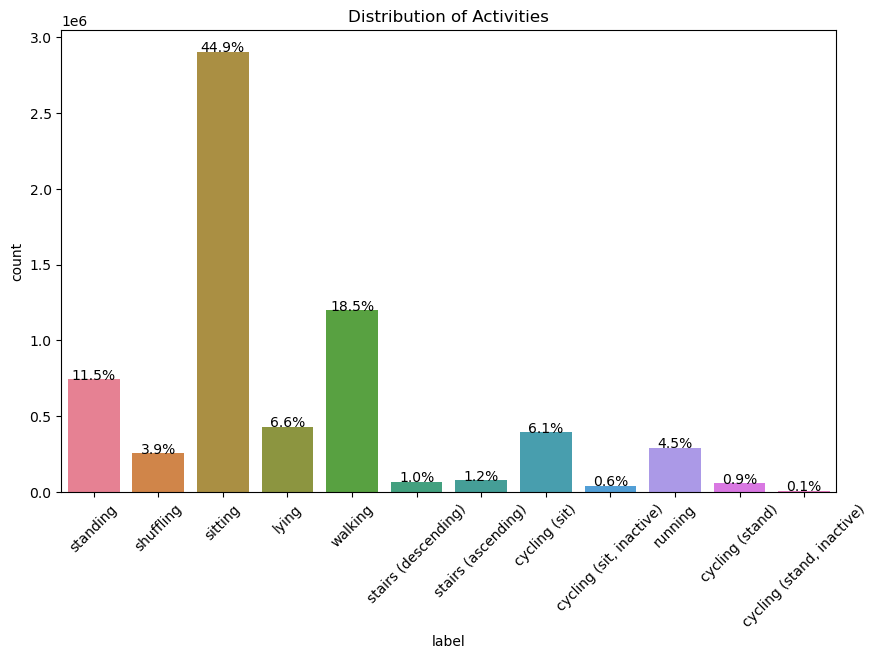

In [6]:
# Calculate percentage of each activity
activity_counts = combined_df['label'].value_counts(normalize=True) * 100

# Define custom color palette
custom_palette = sns.color_palette("husl", len(activity_counts))

# Create countplot
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='label', data=combined_df, palette=custom_palette, hue='label', legend=False)
plt.xticks(rotation=45)
plt.title('Distribution of Activities')

# Add percentage labels to each bar
total = len(combined_df['label'])
for p, label in zip(ax.patches, activity_counts.index):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 0.5, f'{height/total:.1%}', ha='center')

plt.show()

In [7]:
# Descriptive statistics
print("Descriptive Statistics:")
combined_df.describe()

Descriptive Statistics:


,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z
count,6.461328e+06,6.461328e+06,6.461328e+06,6.461328e+06,6.461328e+06,6.461328e+06
mean,-8.849574e-01,-1.326128e-02,-1.693779e-01,-5.948883e-01,2.087665e-02,3.749160e-01
std,3.775916e-01,2.311709e-01,3.647385e-01,6.263466e-01,3.884511e-01,7.360983e-01
min,-8.000000e+00,-4.307617e+00,-6.574463e+00,-8.000000e+00,-7.997314e+00,-8.000000e+00
25%,-1.002393e+00,-8.312914e-02,-3.720700e-01,-9.742110e-01,-1.000873e-01,-1.557138e-01
50%,-9.748998e-01,2.593677e-03,-1.374510e-01,-4.217309e-01,3.262909e-02,7.004390e-01
75%,-8.123032e-01,7.251000e-02,4.647321e-02,-1.678755e-01,1.549512e-01,9.486747e-01
max,2.291708e+00,6.491943e+00,4.909483e+00,7.999756e+00,7.999756e+00,8.406235e+00


## Sensor Readings Descriptive Statistics Across Activities
Comparing sensor data for dynamic activities (like walking and running) with less dynamic ones (like sitting or standing) can highlight the sensors' sensitivity and the potential challenges in distinguishing between low-movement activities.

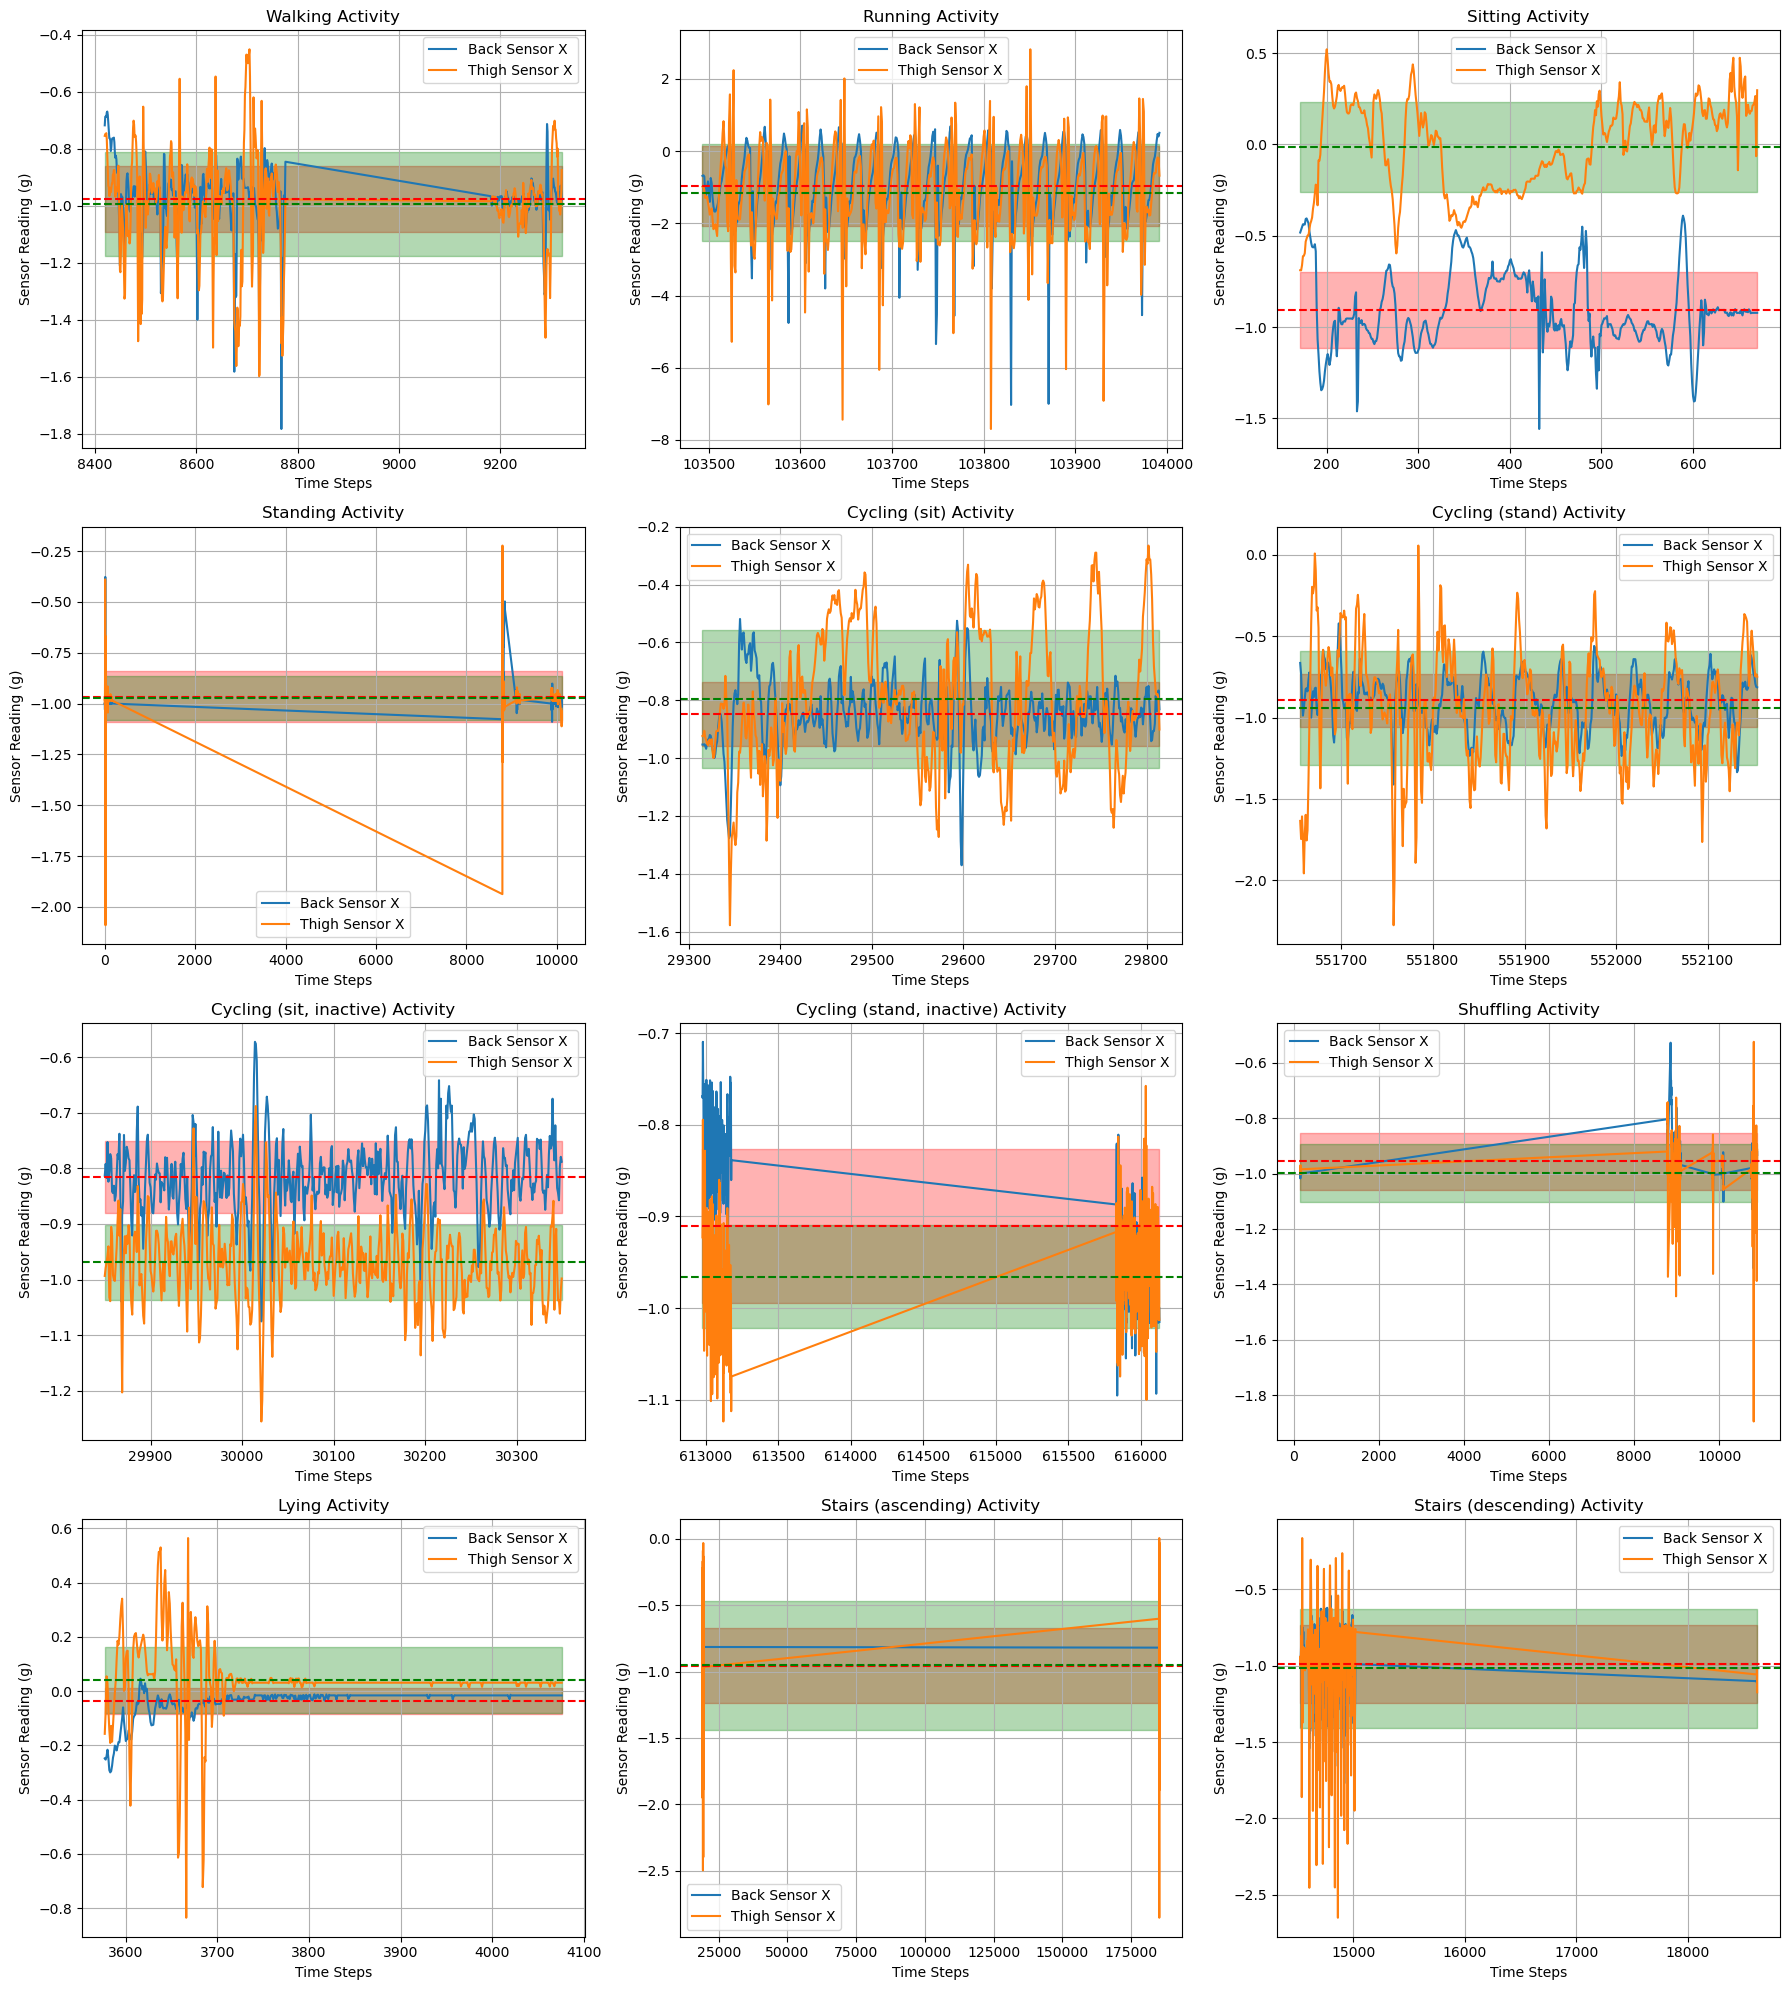

In [8]:
# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 20))

# List of activities
activity_labels = ['walking', 'running', 'sitting', 'standing', 'cycling (sit)', 'cycling (stand)',
                   'cycling (sit, inactive)', 'cycling (stand, inactive)', 'shuffling', 'lying',
                   'stairs (ascending)', 'stairs (descending)']

# Iterate through activities
for idx, activity in enumerate(activity_labels):
    subset_df = combined_df[combined_df['label'] == activity].head(500)
    ax = axes[idx // 3, idx % 3]  # Adjusted indexing to fit all activities
    ax.plot(subset_df['back_x'], label='Back Sensor X')
    ax.plot(subset_df['thigh_x'], label='Thigh Sensor X')
    ax.set_title(f'{activity.capitalize()} Activity')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Sensor Reading (g)')
    ax.legend()
    ax.grid(True)
    ax.axhline(y=subset_df['back_x'].mean(), color='r', linestyle='--', label='Mean Back Sensor X')
    ax.axhline(y=subset_df['thigh_x'].mean(), color='g', linestyle='--', label='Mean Thigh Sensor X')
    ax.fill_between(subset_df.index, subset_df['back_x'].mean() - subset_df['back_x'].std(),
                    subset_df['back_x'].mean() + subset_df['back_x'].std(), alpha=0.3, color='r')
    ax.fill_between(subset_df.index, subset_df['thigh_x'].mean() - subset_df['thigh_x'].std(),
                    subset_df['thigh_x'].mean() + subset_df['thigh_x'].std(), alpha=0.3, color='g')

# Adjust layout
plt.tight_layout()
plt.show()

## Feature Engineering


In [9]:
# Set the window size for rolling mean
window_size = 5

# Calculate the rolling mean for 'back_x' and 'thigh_x' columns
combined_df['back_x_rolling_mean'] = combined_df['back_x'].rolling(window=window_size, min_periods=1).mean()
combined_df['thigh_x_rolling_mean'] = combined_df['thigh_x'].rolling(window=window_size, min_periods=1).mean()

# Print the updated data structure
print('Updated Data Structure After Feature Engineering:')
combined_df.info()

Updated Data Structure After Feature Engineering:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6461328 entries, 0 to 6461327
Data columns (total 10 columns):
 #   Column                Dtype  
---  ------                -----  
 0   timestamp             object 
 1   back_x                float64
 2   back_y                float64
 3   back_z                float64
 4   thigh_x               float64
 5   thigh_y               float64
 6   thigh_z               float64
 7   label                 object 
 8   back_x_rolling_mean   float64
 9   thigh_x_rolling_mean  float64
dtypes: float64(8), object(2)
memory usage: 493.0+ MB


## Outlier Detection and Removal
Removing outliers is crucial for preventing skewed analysis and improving model performance..


In [10]:
# Calculate Z-scores of the data
z_scores = np.abs(stats.zscore(combined_df.select_dtypes(include=[np.number])))

# Define the outlier threshold
outlier_threshold = 3

# Identify and remove outliers
outliers = (z_scores > outlier_threshold).any(axis=1)
combined_df_cleaned = combined_df[(z_scores < outlier_threshold).all(axis=1)]

# Display the shape of the DataFrame before and after outlier removal
print(f"DataFrame shape before outlier removal: {combined_df.shape}")
print(f"DataFrame shape after outlier removal: {combined_df_cleaned.shape}")

DataFrame shape before outlier removal: (6461328, 10)
DataFrame shape after outlier removal: (5899016, 10)


## Final Data Check
Reviewing the dataset after preprocessing steps have been applied.


In [11]:
# Displaying DataFrame information
combined_df_cleaned.info()

# Displaying the first few rows of the DataFrame
combined_df_cleaned.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5899016 entries, 0 to 6461327
Data columns (total 10 columns):
 #   Column                Dtype  
---  ------                -----  
 0   timestamp             object 
 1   back_x                float64
 2   back_y                float64
 3   back_z                float64
 4   thigh_x               float64
 5   thigh_y               float64
 6   thigh_z               float64
 7   label                 object 
 8   back_x_rolling_mean   float64
 9   thigh_x_rolling_mean  float64
dtypes: float64(8), object(2)
memory usage: 495.1+ MB


,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label,back_x_rolling_mean,thigh_x_rolling_mean
0,2019-01-12 00:00:00.000,-1.000000,-0.071289,-0.215332,-0.997070,-0.124268,0.142334,standing,-1.000000,-0.997070
1,2019-01-12 00:00:00.020,-1.000000,-0.084473,-0.210449,-0.964844,-0.107422,0.160645,standing,-1.000000,-0.980957
2,2019-01-12 00:00:00.040,-0.997559,-0.111328,-0.199219,-0.971191,-0.108887,0.170898,standing,-0.999186,-0.977702
3,2019-01-12 00:00:00.060,-1.006592,-0.139160,-0.209717,-0.986084,-0.112061,0.154297,standing,-1.001038,-0.979797
4,2019-01-12 00:00:00.080,-1.030029,-0.140137,-0.228760,-0.985840,-0.127441,0.155029,standing,-1.006836,-0.981006


# Data Visualization 

## Correlation Heatmap
A correlation heatmap provides a visual representation of how the features correlate with each other.

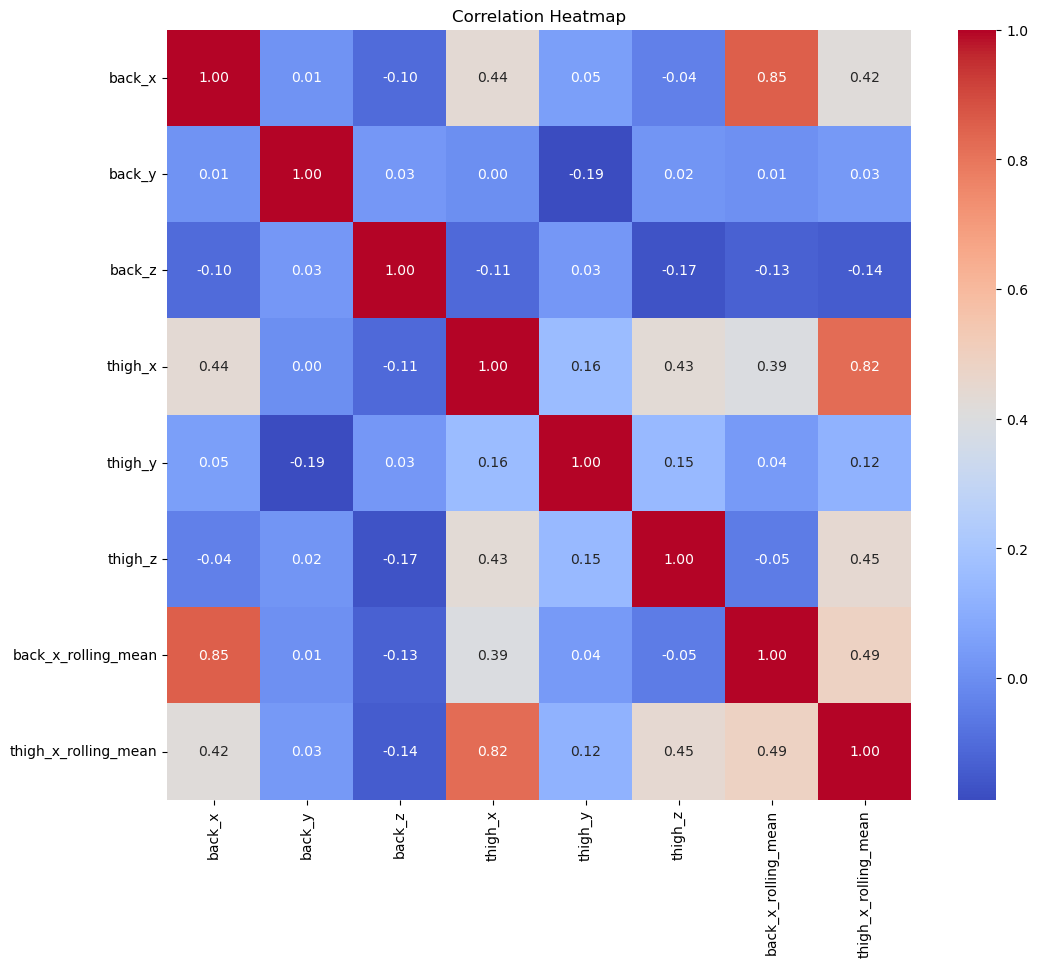

In [12]:
# Correlation Heatmap with explicit numeric_only parameter
plt.figure(figsize=(12, 10))
sensor_columns = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'back_x_rolling_mean', 'thigh_x_rolling_mean']
correlation_matrix = combined_df[sensor_columns].corr() 
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Heatmap')
plt.show()

# Deep Learning Model 1: Convolutional Neural Network (CNN) for Human Activity Recognition (HAR)  function.


This section outlines the development process of a Convolutional Neural Network (CNN) model designed to classify time-series sensor data, augmented with engineered features for improved performance.

### Preprocessing

- **Feature Engineering:**  Rolling mean features from sensor data are created to capture temporal dynamics, enhancing the model's ability to understand time-based trends.
- **Data Standardization:**  Data is normalized using `StandardScaler` to ensure all features contribute equally to the model training, which is crucial for neural network efficiency.
- **Data Reshaping:** The data is reshaped into a format suitable for CNN input, involving samples, timesteps, and features, allowing the CNN to process temporal sequences.

In [13]:
# Select engineered features from the cleaned DataFrame
engineered_features = combined_df_cleaned[['back_x_rolling_mean', 'thigh_x_rolling_mean']].values

# Scale the engineered features
scaler_engineered = StandardScaler()
engineered_features_scaled = scaler_engineered.fit_transform(engineered_features)

# Prepare sensor data from the cleaned DataFrame
sensor_columns = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
X = combined_df_cleaned[sensor_columns].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for CNN input
timesteps = 198  # Update the number of timesteps based on your data
features = 6  # Number of sensor columns
samples = len(X_scaled) // timesteps
X_reshaped = X_scaled[:samples * timesteps].reshape((samples, timesteps, features))

# Reshape engineered features to align with samples
engineered_features_reshaped = engineered_features_scaled[:samples]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(combined_df_cleaned['label'].values[:samples])
y_categorical = to_categorical(y_encoded)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)
engineered_features_train = engineered_features_reshaped[:len(X_train)]
engineered_features_test = engineered_features_reshaped[len(X_train):]

### Model Training 
- **Early Stopping** The model employs early stopping to halt training when the validation loss ceases to improve, thus preventing overfitting.
- **Model Checkpointing** Saves the model at its peak validation performance for later use or evaluation.
- **Evaluation Metrics** Post-training, it's crucial to assess the model's performance on the test data using metrics such asAccuracy, Precision, Recall and F1 Score

In [14]:
def create_simplified_cnn_model(timesteps, features, engineered_features_shape, num_classes):
    cnn_input = Input(shape=(timesteps, features), name='cnn_input')
    
    # Simplified Convolutional Block
    x = Conv1D(filters=32, kernel_size=3, activation='relu')(cnn_input)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)

    # Flattening the output for the Dense layer
    cnn_output = Flatten()(x)
    
    # Input for engineered features
    features_input = Input(shape=(engineered_features_shape,), name='features_input')
    
    # Combine CNN output with engineered features
    combined = Concatenate()([cnn_output, features_input])
    
    # Dense layer followed by the output layer
    x = Dense(64, activation='relu')(combined)
    x = Dropout(0.2)(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    # Model definition
    model = Model(inputs=[cnn_input, features_input], outputs=output)
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Create the simplified CNN model
simplified_cnn_model = create_simplified_cnn_model(timesteps, features, engineered_features_train.shape[1], y_train.shape[1])

# Callbacks setup
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('simplified_cnn_model_best.keras', monitor='val_loss', save_best_only=True)

# Training the model
history = simplified_cnn_model.fit(
    [X_train, engineered_features_train], y_train,
    validation_data=([X_test, engineered_features_test], y_test),
    epochs=50,  # Adjusted for simplicity
    batch_size=64,  
    callbacks=[early_stopping, model_checkpoint]
)



Epoch 1/50


373/373 [==============================] - 8s 14ms/step - loss: 1.3338 - accuracy: 0.4854 - val_loss: 1.1140 - val_accuracy: 0.5560
Epoch 2/50
373/373 [==============================] - 5s 14ms/step - loss: 1.1341 - accuracy: 0.5564 - val_loss: 1.0610 - val_accuracy: 0.5842
Epoch 3/50
373/373 [==============================] - 5s 14ms/step - loss: 1.0586 - accuracy: 0.5827 - val_loss: 1.0083 - val_accuracy: 0.5949
Epoch 4/50
373/373 [==============================] - 6s 15ms/step - loss: 1.0076 - accuracy: 0.6011 - val_loss: 0.9688 - val_accuracy: 0.6199
Epoch 5/50
373/373 [==============================] - 6s 15ms/step - loss: 0.9588 - accuracy: 0.6228 - val_loss: 0.9146 - val_accuracy: 0.6404
Epoch 6/50
373/373 [==============================] - 5s 14ms/step - loss: 0.9300 - accuracy: 0.6333 - val_loss: 0.9117 - val_accuracy: 0.6444
Epoch 7/50
373/373 [==============================] - 5s 13ms/step - loss: 0.8995 - accuracy: 0.6419 - val_loss: 0.9114 - val_accuracy: 0.

### Model Evaluation or underfitting.


Evaluate the CNN model on the test dataset to assess its performance, focusing on accuracy, precision, recall, and F1 score to understand its classification capabilities. Visualize the training process to identify learning patterns and potential overfitting.

187/187 [==============================] - 1s 5ms/step - loss: 0.8384 - accuracy: 0.7010
Test Loss: 0.8384160399436951, Test Accuracy: 0.7009565234184265
187/187 [==============================] - 1s 4ms/step
CNN Model - Accuracy: 0.70, Precision: 0.69, Recall: 0.63, F1 Score: 0.63

Classification Report:
                            precision    recall  f1-score   support

            cycling (sit)       0.90      0.91      0.91       655
  cycling (sit, inactive)       0.72      0.36      0.48       187
          cycling (stand)       0.71      0.49      0.58        72
cycling (stand, inactive)       0.66      0.81      0.72      2128
                  running       0.46      1.00      0.63        17
                shuffling       0.63      0.44      0.52       793
                  sitting       0.82      0.85      0.83       977
                 standing       0.60      0.52      0.56      1040
                  walking       0.70      0.31      0.43        90

                 acc

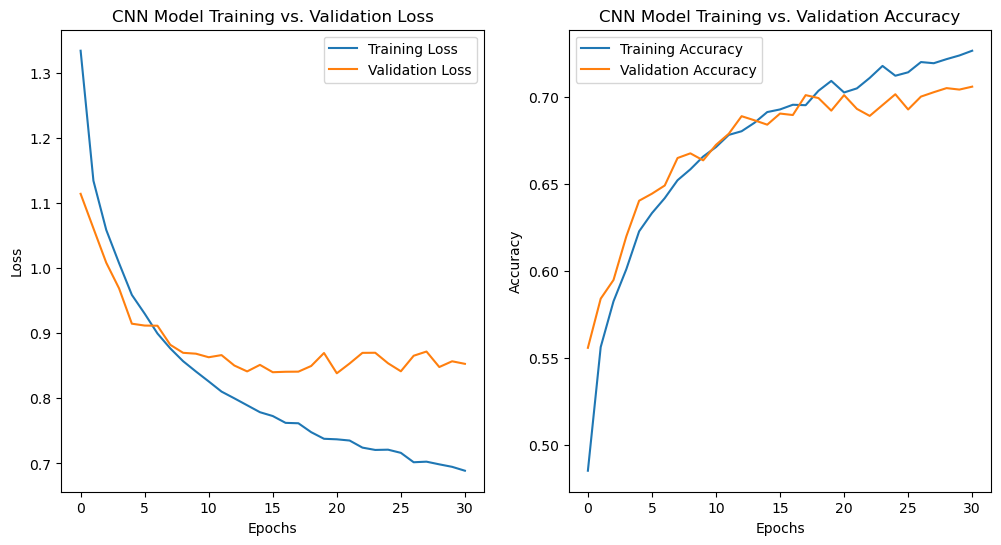

In [15]:
# Evaluate the simplified CNN model on the test set
test_loss, test_accuracy_cnn = simplified_cnn_model.evaluate([X_test, engineered_features_test], y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy_cnn}")

# Generate predictions on the test set
y_pred_cnn = np.argmax(simplified_cnn_model.predict([X_test, engineered_features_test]), axis=1)
y_true_cnn = np.argmax(y_test, axis=1)

# Convert numerical labels to their original string labels using the activity_labels mapping
y_true_labels_str = [activity_labels[label] for label in y_true_cnn]
y_pred_labels_str = [activity_labels[label] for label in y_pred_cnn]

# Calculate performance metrics
accuracy_cnn = accuracy_score(y_true_cnn, y_pred_cnn)
precision_cnn = precision_score(y_true_cnn, y_pred_cnn, average='macro', zero_division=0)
recall_cnn = recall_score(y_true_cnn, y_pred_cnn, average='macro', zero_division=0)
f1_cnn = f1_score(y_true_cnn, y_pred_cnn, average='macro', zero_division=0)

print(f"CNN Model - Accuracy: {accuracy_cnn:.2f}, Precision: {precision_cnn:.2f}, Recall: {recall_cnn:.2f}, F1 Score: {f1_cnn:.2f}")

# Generate the classification report using the string labels
report = classification_report(y_true_labels_str, y_pred_labels_str, zero_division=0)
print("\nClassification Report:\n", report)

# Visualizing Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Model Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Visualizing Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Training vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Deep Learning Model 2: Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) for Human Activity Recognition (HAR)

### Preprocessing

- **Feature Engineering** Extracted rolling mean features (`back_x_rolling_mean`, `thigh_x_rolling_mean`) from sensor data to capture temporal patterns.
- **Data Standardization** Applied `StandardScaler` to both sensor data and engineered features to normalize distributions, enhancing model training efficiency.
- **Data Reshaping** Transformed sensor data into a 3D array (samples, timesteps, features) suitable for RNN, preserving temporal sequence information.
- **Label Encoding** Converted categorical labels into a binary class matrix for multi-class classification compatibility.
- **Train-Test Split** Divided the dataset into training and testing sets to assess model performance on unseen data.

In [16]:
# Select engineered features from the cleaned DataFrame
engineered_features = combined_df_cleaned[['back_x_rolling_mean', 'thigh_x_rolling_mean']].values

# Scale the engineered features
scaler_engineered = StandardScaler()
engineered_features_scaled = scaler_engineered.fit_transform(engineered_features)

# Prepare sensor data from the cleaned DataFrame
sensor_columns = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
X = combined_df_cleaned[sensor_columns].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for RNN input
timesteps = 198  # Update based on your sequence length
features = 6  # Number of sensor columns
samples = len(X_scaled) // timesteps
X_reshaped = X_scaled[:samples * timesteps].reshape((samples, timesteps, features))

# Reshape engineered features to align with samples
engineered_features_reshaped = engineered_features_scaled[:samples]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(combined_df_cleaned['label'].values[:samples])
y_categorical = to_categorical(y_encoded)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)
engineered_features_train = engineered_features_reshaped[:len(X_train)]
engineered_features_test = engineered_features_reshaped[len(X_train):]

### Model Training
- **Architecture** The model uses LSTM layers to process sensor data, capturing temporal dependencies, and combines it with engineered features for enhanced context.
- **Regularization** Dropout layers are integrated to mitigate overfitting, promoting a more robust generalization.
- **Optimization** Compiled with Adam optimizer and categorical crossentropy, the model is fine-tuned for a multi-class classification task.
- **Callbacks** EarlyStopping monitors validation loss to halt training at the right moment, while ModelCheckpoint saves the best performing model iteration.

In [23]:
def create_simplified_rnn_model(timesteps, features, engineered_features_shape, num_classes):
    # Sensor data input
    sensor_input = Input(shape=(timesteps, features), name='sensor_input')
    x = LSTM(units=32)(sensor_input)  # Simplified LSTM layer
    rnn_output = Dropout(0.2)(x)  # Simplified dropout

    # Input for engineered features
    features_input = Input(shape=(engineered_features_shape,), name='features_input')

    # Combine RNN output with engineered features
    combined = Concatenate()([rnn_output, features_input])
    x = Dense(64, activation='relu')(combined)  # Simplified dense layer
    output = Dense(num_classes, activation='softmax')(x)

    # Model definition
    model = Model(inputs=[sensor_input, features_input], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the simplified RNN model
simplified_rnn_model = create_simplified_rnn_model(timesteps, features, engineered_features_train.shape[1], y_train.shape[1])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_simplified_rnn_model.keras', monitor='val_loss', save_best_only=True)

# Train the simplified RNN model
history = simplified_rnn_model.fit(
    [X_train, engineered_features_train], y_train,
    validation_data=([X_test, engineered_features_test], y_test),
    epochs=75,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/75
373/373 [==============================] - 23s 55ms/step - loss: 1.4676 - accuracy: 0.4533 - val_loss: 1.3396 - val_accuracy: 0.5051
Epoch 2/75
373/373 [==============================] - 21s 55ms/step - loss: 1.3236 - accuracy: 0.4909 - val_loss: 1.2203 - val_accuracy: 0.5363
Epoch 3/75
373/373 [==============================] - 20s 53ms/step - loss: 1.2405 - accuracy: 0.5231 - val_loss: 1.2284 - val_accuracy: 0.5246
Epoch 4/75
373/373 [==============================] - 20s 53ms/step - loss: 1.2273 - accuracy: 0.5314 - val_loss: 1.1946 - val_accuracy: 0.5472
Epoch 5/75
373/373 [==============================] - 21s 55ms/step - loss: 1.2018 - accuracy: 0.5404 - val_loss: 1.1453 - val_accuracy: 0.5573
Epoch 6/75
373/373 [==============================] - 20s 53ms/step - loss: 1.1941 - accuracy: 0.5383 - val_loss: 1.1552 - val_accuracy: 0.5531
Epoch 7/75
373/373 [==============================] - 20s 55ms/step - loss: 1.1586 - accuracy: 0.5540 - val_loss: 1.1190 - val_accuracy:

### Model EvaluationAfter evaluating the simplified RNN model, we observed a test accuracy and loss that provide insights into the model's generalization capabilities. Generating predictions on the test set allowed for calculating key metrics such as accuracy, precision, recall, and F1 score, offering a comprehensive view of the model's performance. The classification report and visualizations of training/validation accuracy and loss further detailed the model's effectiveness and learning behavior throughout the training epochs.ect



187/187 [==============================] - 3s 15ms/step - loss: 0.8387 - accuracy: 0.6746
Test Loss: 0.8386865854263306, Test Accuracy: 0.6746098399162292
187/187 [==============================] - 3s 14ms/step
RNN Model - Accuracy: 0.67, Precision: 0.68, Recall: 0.61, F1 Score: 0.60
                           precision    recall  f1-score   support

            cycling (sit)       0.88      0.93      0.90       655
  cycling (sit, inactive)       0.77      0.30      0.44       187
          cycling (stand)       0.90      0.36      0.51        72
cycling (stand, inactive)       0.64      0.80      0.71      2128
                  running       0.45      1.00      0.62        17
                shuffling       0.58      0.39      0.47       793
                  sitting       0.85      0.78      0.82       977
                 standing       0.52      0.47      0.50      1040
                  walking       0.53      0.44      0.48        90

                 accuracy                  

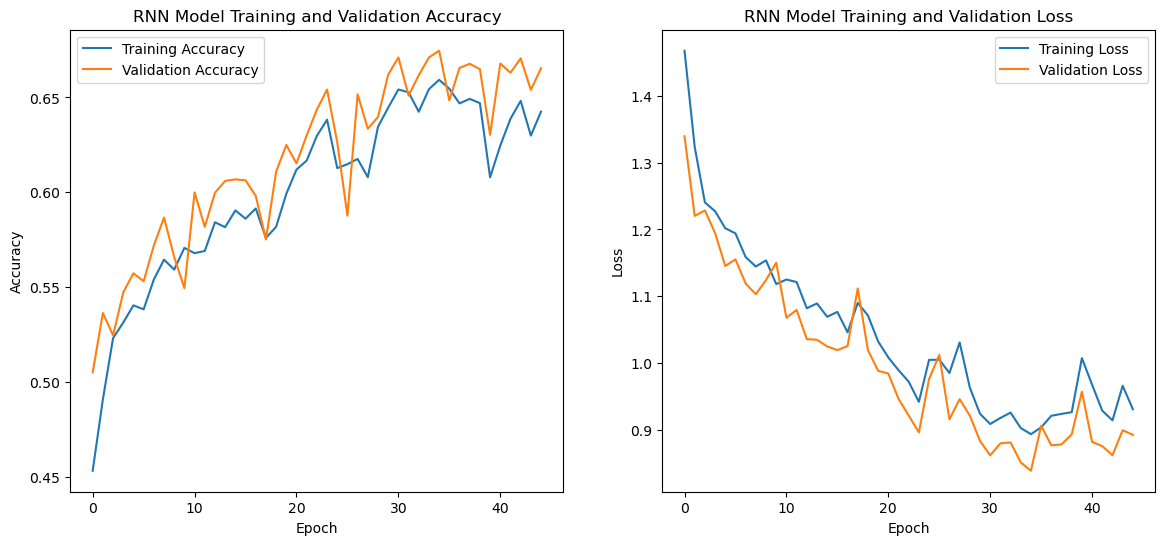

In [24]:
# Evaluate the simplified RNN model
test_loss, test_accuracy = simplified_rnn_model.evaluate([X_test, engineered_features_test], y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Generate predictions and calculate metrics
y_pred_rnn = np.argmax(simplified_rnn_model.predict([X_test, engineered_features_test]), axis=1)
y_true_rnn = np.argmax(y_test, axis=1)

accuracy_rnn = accuracy_score(y_true_rnn, y_pred_rnn)
precision_rnn = precision_score(y_true_rnn, y_pred_rnn, average='macro', zero_division=0)
recall_rnn = recall_score(y_true_rnn, y_pred_rnn, average='macro', zero_division=0)
f1_rnn = f1_score(y_true_rnn, y_pred_rnn, average='macro', zero_division=0)

print(f"RNN Model - Accuracy: {accuracy_rnn:.2f}, Precision: {precision_rnn:.2f}, Recall: {recall_rnn:.2f}, F1 Score: {f1_rnn:.2f}")

# Convert numerical labels to their original string labels using the activity_labels mapping
y_true_labels_str = [activity_labels[label] for label in y_true_rnn]
y_pred_labels_str = [activity_labels[label] for label in y_pred_rnn]

# Generate the classification report using the string labels
report = classification_report(y_true_labels_str, y_pred_labels_str, zero_division=0)
print(report)

# Plot Accuracy and Loss
plt.figure(figsize=(14, 6))

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('RNN Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('RNN Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Deep Learning Model 3: CNN-RNN Hybrid Model for Human Activity Recognition (HAR) 

- **Feature Selection**: Extracting rolling mean features from sensor data to capture temporal dynamics.
- **Scaling**: Normalizing both sensor and engineered features to have a mean of 0 and a standard deviation of 1, enhancing model training efficiency.
- **Reshaping**: Adjusting the data shape to fit the input requirements of CNN/RNN models, maintaining the integrity of temporal sequences.
- **Encoding**: Transforming categorical labels into a format suitable for neural network output, facilitating multi-class classification.
- **Splitting**: Dividing the dataset into training and testing sets to ensure a robust evaluation of the model's performance on unseen data.

In [25]:
# Select engineered features from the cleaned DataFrame
engineered_features = combined_df_cleaned[['back_x_rolling_mean', 'thigh_x_rolling_mean']].values

# Scale the engineered features
scaler_engineered = StandardScaler()
engineered_features_scaled = scaler_engineered.fit_transform(engineered_features)

# Prepare sensor data from the cleaned DataFrame
sensor_columns = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
X = combined_df_cleaned[sensor_columns].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for CNN/RNN input
timesteps = 198  # Update based on your sequence length
features = 6  # Number of sensor columns
samples = len(X_scaled) // timesteps
X_reshaped = X_scaled[:samples * timesteps].reshape((samples, timesteps, features))

# Reshape engineered features to align with samples
engineered_features_reshaped = engineered_features_scaled[:samples]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(combined_df_cleaned['label'].values[:samples])
y_categorical = to_categorical(y_encoded)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)
engineered_features_train = engineered_features_reshaped[:len(X_train)]
engineered_features_test = engineered_features_reshaped[len(X_train):]


### Model Training
- **CNN Component**: Processes sensor data through convolutional and pooling layers to capture spatial features and reduce dimensionality.
- **RNN Component**: Utilizes LSTM units to analyze temporal sequences in the data, capturing long-term dependencies.
- **Engineered Features Integration**: Includes additional engineered features directly into the network to provide contextual information that may not be captured by raw sensor data alone.
- **Combination and Final Classification**: The outputs from CNN, RNN, and engineered features are concatenated and fed through dense layers for final classification.

The model is compiled with the Adam optimizer and categorical crossentropy loss, targeting a multi-class classification problem. Training incorporates EarlyStopping and ModelCheckpoint callbacks to prevent overfitting and save the best model iteration based on validation performance.

In [26]:
def create_simplified_hybrid_model(timesteps, features, engineered_features_shape, num_classes):
    # Simplified CNN part
    cnn_input = Input(shape=(timesteps, features), name='cnn_input')
    cnn = Conv1D(filters=32, kernel_size=3, activation='relu')(cnn_input)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn_output = Flatten()(cnn)

    # Simplified RNN part
    rnn_input = Input(shape=(timesteps, features), name='rnn_input')
    rnn = LSTM(units=32)(rnn_input)
    rnn_output = Dropout(0.2)(rnn)

    # Input for engineered features
    features_input = Input(shape=(engineered_features_shape,), name='features_input')

    # Combine CNN, RNN, and engineered features
    combined = Concatenate()([cnn_output, rnn_output, features_input])
    x = Dense(64, activation='relu')(combined)
    output = Dense(num_classes, activation='softmax')(x)

    # Model definition
    model = Model(inputs=[cnn_input, rnn_input, features_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the simplified hybrid model
simplified_hybrid_model = create_simplified_hybrid_model(timesteps, features, engineered_features_train.shape[1], y_train.shape[1])

# Callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_simplified_hybrid_model.keras', monitor='val_loss', save_best_only=True)

# Train the simplified hybrid model
history = simplified_hybrid_model.fit(
    [X_train, X_train, engineered_features_train], y_train,
    validation_data=([X_test, X_test, engineered_features_test], y_test),
    epochs=30,  # Reduced epochs for simplicity
    batch_size=64,  
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/30
373/373 [==============================] - 27s 66ms/step - loss: 1.2230 - accuracy: 0.5249 - val_loss: 1.0900 - val_accuracy: 0.5823
Epoch 2/30
373/373 [==============================] - 22s 60ms/step - loss: 0.9879 - accuracy: 0.6111 - val_loss: 0.9590 - val_accuracy: 0.6296
Epoch 3/30
373/373 [==============================] - 23s 61ms/step - loss: 0.8856 - accuracy: 0.6564 - val_loss: 0.9108 - val_accuracy: 0.6496
Epoch 4/30
373/373 [==============================] - 22s 58ms/step - loss: 0.8183 - accuracy: 0.6839 - val_loss: 0.8708 - val_accuracy: 0.6771
Epoch 5/30
373/373 [==============================] - 22s 59ms/step - loss: 0.7739 - accuracy: 0.7054 - val_loss: 0.9141 - val_accuracy: 0.6614
Epoch 6/30
373/373 [==============================] - 22s 58ms/step - loss: 0.7234 - accuracy: 0.7251 - val_loss: 0.8507 - val_accuracy: 0.6783
Epoch 7/30
373/373 [==============================] - 22s 59ms/step - loss: 0.6917 - accuracy: 0.7359 - val_loss: 0.8427 - val_accuracy:

### Model Evaluation
The evaluation of the simplified hybrid model on the test dataset highlighted its effectiveness, with notable accuracy and precision metrics reflecting its capability to integrate spatial and temporal features alongside engineered data for robust classification. The comprehensive performance metrics, including accuracy, precision, recall, and F1 score, underscore the model's balanced classification prowess across various classes.


187/187 [==============================] - 3s 15ms/step - loss: 0.8413 - accuracy: 0.6996
Test Loss: 0.8413010835647583, Test Accuracy: 0.6996140480041504
187/187 [==============================] - 3s 16ms/step
Hybrid Model - Accuracy: 0.70, Precision: 0.72, Recall: 0.66, F1 Score: 0.68
                           precision    recall  f1-score   support

            cycling (sit)       0.90      0.87      0.89       655
  cycling (sit, inactive)       0.68      0.45      0.54       187
          cycling (stand)       0.67      0.40      0.50        72
cycling (stand, inactive)       0.66      0.82      0.73      2128
                  running       0.89      1.00      0.94        17
                shuffling       0.62      0.49      0.55       793
                  sitting       0.83      0.81      0.82       977
                 standing       0.61      0.46      0.53      1040
                  walking       0.59      0.61      0.60        90

                 accuracy               

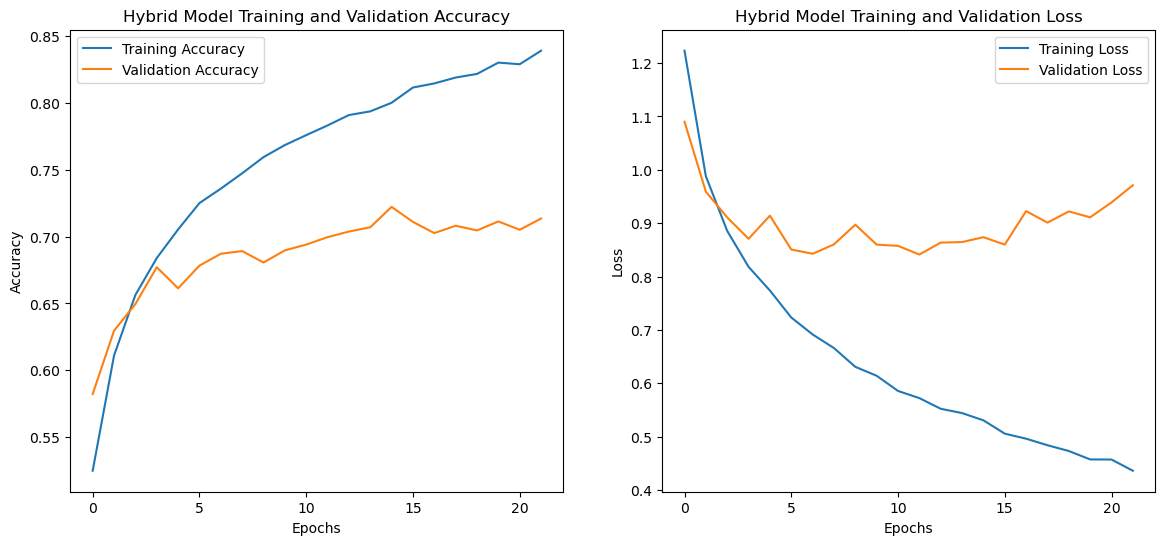

In [27]:
# Evaluate the simplified hybrid model
test_loss, test_accuracy_hybrid = simplified_hybrid_model.evaluate([X_test, X_test, engineered_features_test], y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy_hybrid}")

# Generate predictions and calculate metrics
y_pred_hybrid = np.argmax(simplified_hybrid_model.predict([X_test, X_test, engineered_features_test]), axis=1)
y_true_hybrid = np.argmax(y_test, axis=1)

accuracy_hybrid = accuracy_score(y_true_hybrid, y_pred_hybrid)
precision_hybrid = precision_score(y_true_hybrid, y_pred_hybrid, average='macro', zero_division=0)
recall_hybrid = recall_score(y_true_hybrid, y_pred_hybrid, average='macro', zero_division=0)
f1_hybrid = f1_score(y_true_hybrid, y_pred_hybrid, average='macro', zero_division=0)

print(f"Hybrid Model - Accuracy: {accuracy_hybrid:.2f}, Precision: {precision_hybrid:.2f}, Recall: {recall_hybrid:.2f}, F1 Score: {f1_hybrid:.2f}")

# Mapping dictionary named 'activity_labels'
y_true_labels_str = [activity_labels[label] for label in y_true_hybrid]
y_pred_labels_str = [activity_labels[label] for label in y_pred_hybrid]

# Generate the classification report using the string labels
report = classification_report(y_true_labels_str, y_pred_labels_str, zero_division=0)
print(report)

# Plot Training and Validation Accuracy and Loss
plt.figure(figsize=(14, 6))

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Hybrid Model Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Hybrid Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Deep Learning Model Comparison: CNN, RNN & Hybrid

This section presents a comparative analysis of the three models: CNN, RNN, and Hybrid, based on key performance metrics: Accuracy, Precision, and F1 Score. The comparison aims to highlight the strengths and weaknesses of each model in the context of the given classification task, providing insights into their relative effectiveness.

A bar chart visualization is used to depict the scores for each model, facilitating an intuitive understanding of their performance differences. The chart includes:

- **Accuracy Bars**: Representing the overall correctness of each model.
- **Precision Bars**: Indicating the models' ability to minimize false positives.
- **F1 Bars**: Combining precision and recall into a single metric, particularly useful for imbalanced datasets.

The comparison serves as a guide for selecting the most suitable model for similar tasks or identifying areas for further improvement in each models design.


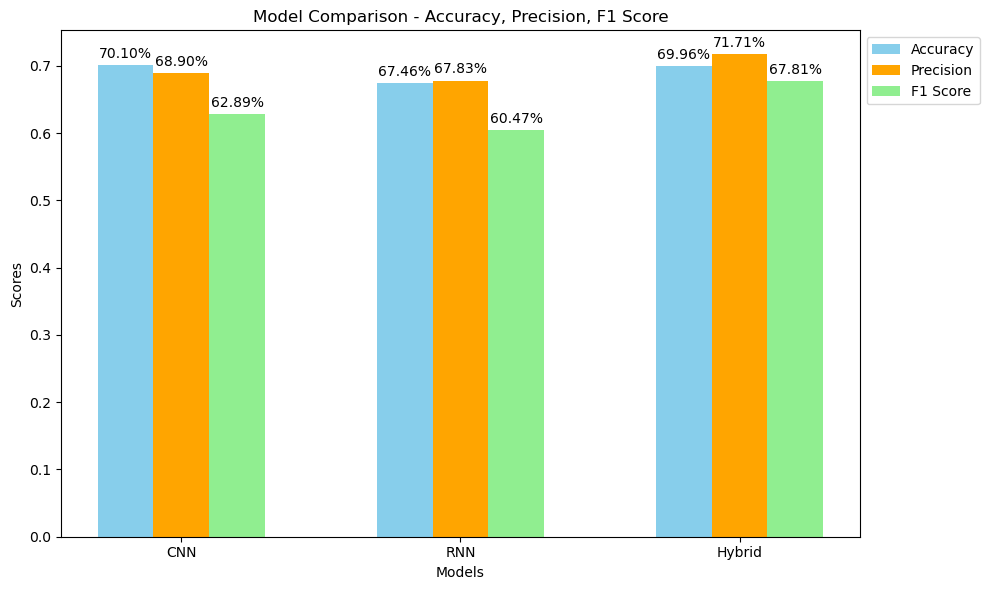

In [28]:
# Data
accuracy_scores = [accuracy_cnn, accuracy_rnn, accuracy_hybrid]
precision_scores = [precision_cnn, precision_rnn, precision_hybrid]
f1_scores = [f1_cnn, f1_rnn, f1_hybrid]
models = ['CNN', 'RNN', 'Hybrid']

# Plot settings
pos = np.arange(len(models))
bar_width = 0.2
plt.figure(figsize=(10, 6))

# Plot bars
accuracy_bars = plt.bar(pos, accuracy_scores, bar_width, label='Accuracy', color='skyblue')
precision_bars = plt.bar(pos + bar_width, precision_scores, bar_width, label='Precision', color='orange')
f1_bars = plt.bar(pos + 2 * bar_width, f1_scores, bar_width, label='F1 Score', color='lightgreen')

# Plot customization
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Comparison - Accuracy, Precision, F1 Score')
plt.xticks(pos + bar_width, models)

# Move legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Add labels on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2%}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords='offset points',
                     ha='center', va='bottom')

add_labels(accuracy_bars)
add_labels(precision_bars)
add_labels(f1_bars)

# Show plot with adjustments
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

## Conversion of Numeric Labels to Activity Names for Model Comparison

In [36]:
# Generate predictions for the CNN model
y_pred_proba_cnn = simplified_cnn_model.predict([X_test, engineered_features_test])  # Use this if your model requires engineered features


# Convert probabilistic predictions to numeric labels
y_pred_labels_cnn = np.argmax(y_pred_proba_cnn, axis=1)

# Convert the one-hot encoded true labels to numeric labels
y_true_labels = np.argmax(y_test, axis=1)

# Convert numeric labels to activity names for CNN
y_true_activity_cnn = [activity_labels[label] for label in y_true_labels]
y_pred_activity_cnn = [activity_labels[label] for label in y_pred_labels_cnn]

# Print classification report for CNN model
print("CNN Model Classification Report:")
print(classification_report(y_true_activity_cnn, y_pred_activity_cnn, zero_division=0))

187/187 [==============================] - 0s 2ms/step
CNN Model Classification Report:
                           precision    recall  f1-score   support

            cycling (sit)       0.90      0.91      0.91       655
  cycling (sit, inactive)       0.72      0.36      0.48       187
          cycling (stand)       0.71      0.49      0.58        72
cycling (stand, inactive)       0.66      0.81      0.72      2128
                  running       0.46      1.00      0.63        17
                shuffling       0.63      0.44      0.52       793
                  sitting       0.82      0.85      0.83       977
                 standing       0.60      0.52      0.56      1040
                  walking       0.70      0.31      0.43        90

                 accuracy                           0.70      5959
                macro avg       0.69      0.63      0.63      5959
             weighted avg       0.70      0.70      0.69      5959



The hybrid CNN-RNN model demonstrates promising results in recognizing human activities from sensor data. Future work may explore further optimization of the model architecture, hyperparameter tuning, and the incorporation of additional data sources to enhance performance and robustnesss.
